In [18]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.preprocessing import StandardScaler, PowerTransformer, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.neighbors import KNeighborsRegressor


In [19]:

df = pd.read_csv("../data/insurance.csv")
df.head()


,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [20]:
num_features = ['age', 'bmi', 'children']
cat_features = ['sex', 'smoker', 'region']


### Baseline Model Performance (Before Scaling)

- The baseline Linear Regression model achieves an R² score of 0.11.
- This low score is expected due to the presence of features with different scales and skewed distributions.
- At this stage, the model serves as a reference point to evaluate the impact of preprocessing techniques applied in later stages.


In [41]:
lr = LinearRegression()
cv_scores_lr = cross_val_score(lr, pd.get_dummies(X, drop_first=True), y, cv=5, scoring='r2')
print("Linear Regression CV R² (baseline):", cv_scores_lr.mean())

Linear Regression CV R² (baseline): 0.11713973976953998


### Scaling & Power Transformation of Features
- Applied PowerTransformer on numerical features to reduce skew.
- StandardScaler applied to normalize the scale.
- Observation: CV R² did not improve (~0.11) compared to baseline.
- Reason:
    - Linear Regression is scale-invariant; scaling does not improve model.
    - Features alone (bmi, age, children) are weak predictors.
    - Transformation only reduces skew but doesn’t add predictive power.


In [42]:


X_pt = X.copy()
pt = PowerTransformer(method='yeo-johnson')
X_pt[['bmi']] = pt.fit_transform(X_pt[['bmi']])
X_pt[num_features] = StandardScaler().fit_transform(X_pt[num_features])
X_pt = pd.get_dummies(X_pt, drop_first=True)

cv_pt = cross_val_score(lr, X_pt, y, cv=5, scoring='r2')
print("CV R² after PowerTransformer on BMI:", cv_pt.mean())


CV R² after PowerTransformer on BMI: 0.1171540824128775


### One-Hot Encoding Effect
- Added One-Hot Encoded categorical features: 'sex', 'region', 'smoker'.
- Observation: CV R² improved dramatically (~0.12 → 0.75).
- Reason: The 'smoker' feature is a strong predictor of charges; adding it allows Linear Regression to explain most variance.
- Note: Scaling alone had no effect; adding meaningful categorical features makes the biggest difference.


In [43]:

X_orig = pd.read_csv('../data/insurance.csv').drop('charges', axis=1)  # keeps all original columns

num_features = ['age', 'bmi', 'children']
cat_features = ['sex', 'region', 'smoker']

# Use scaled numerical columns
X_num_scaled = X_scaled[num_features]  # X_scaled should have only numerical features scaled

# Take categorical columns from original
X_cat = X_orig[cat_features]

# Combine scaled numerical + categorical for encoding
import pandas as pd
X_combined = pd.concat([X_num_scaled.reset_index(drop=True), X_cat.reset_index(drop=True)], axis=1)

# Apply One-Hot Encoding


preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(drop='first', sparse_output=False), cat_features)
    ],
    remainder='passthrough'  # keep numerical columns
)

X_ohe = preprocessor.fit_transform(X_combined)

print("Shape after One-Hot Encoding:", X_ohe.shape)
cv_ohe = cross_val_score(lr, X_ohe, y, cv=5, scoring='r2')
print("CV R² after One-Hot Encoding:", cv_ohe.mean())



Shape after One-Hot Encoding: (1338, 8)
CV R² after One-Hot Encoding: 0.7468616243473741


### Effect of Standardization

- Before standardization, features have different scales and ranges.
- After standardization, all features are centered around zero with similar spread.
- Standardization reduces the dominance of high-magnitude features and improves model learning.


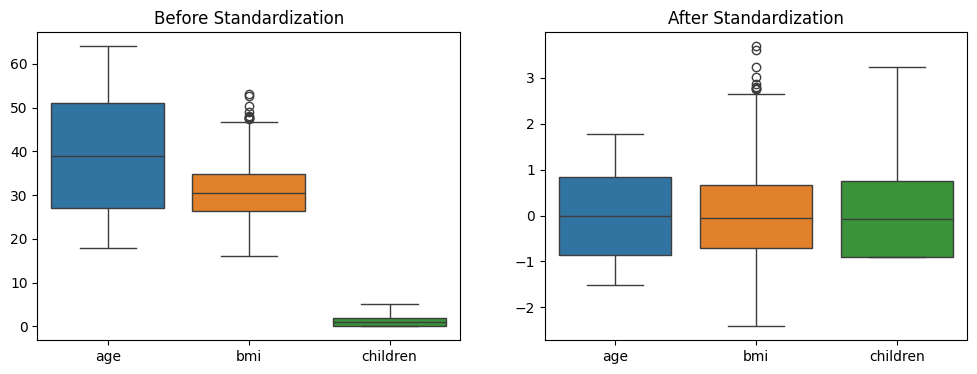

In [52]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

sns.boxplot(data=X, ax=ax[0])
ax[0].set_title("Before Standardization")

sns.boxplot(data=X_scaled, ax=ax[1])
ax[1].set_title("After Standardization")

plt.show()


### Effect of Standardization on Linear Regression

- The R² score remains unchanged after standardization.
- This is expected because Linear Regression without regularization is scale-invariant.
- Standardization primarily benefits models that rely on distance-based optimization or regularization.


In [53]:
num_features = ['age', 'bmi', 'children']
X_scaled = X.copy()
scaler = StandardScaler()
X_scaled[num_features] = scaler.fit_transform(X[num_features])
X_scaled = pd.get_dummies(X_scaled, drop_first=True)

cv_scaled = cross_val_score(lr, X_scaled, y, cv=5, scoring='r2')
print("CV R² after StandardScaler:", cv_scaled.mean())


CV R² after StandardScaler: 0.1171397397695401


### Why Log-Transform Improved R²
- 'charges' is highly skewed; extreme values dominate Linear Regression.
- Log-transform reduces skew, stabilizes variance.
- Linear model can fit low and high charges better, improving R² drastically.


In [54]:
y_log = np.log1p(y)  # log(1 + charges)
cv_scaled_target = cross_val_score(lr, X_scaled, y_log, cv=5, scoring='r2')
print("CV R² after scaling + log-transform target:", cv_scaled_target.mean())


CV R² after scaling + log-transform target: 0.29937907265018204


### Why Interaction Features Improved R²
- 'smoker' alone captures only part of variance.
- Interaction terms (smoker × bmi, smoker × age) allow model to capture combined effects.
- Explains much more variance, drastically improving CV R².


In [49]:
# (before any encoding or get_dummies)
X_orig = pd.read_csv('../data/insurance.csv').drop('charges', axis=1)

# Start from your scaled numerical features
X_inter = X_scaled.copy()  # X_scaled has scaled numerical columns

# Encode smoker from the original data
X_inter['smoker_encoded'] = X_orig['smoker'].map({'yes':1, 'no':0})

# Add interaction terms with scaled numerical columns
X_inter['smoker_bmi'] = X_inter['smoker_encoded'] * X_inter['bmi']
X_inter['smoker_age'] = X_inter['smoker_encoded'] * X_inter['age']



In [55]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
cv_inter = cross_val_score(lr, X_inter, np.log1p(y), cv=5, scoring='r2')
print("CV R² after interaction features:", cv_inter.mean())


CV R² after interaction features: 0.8156608595780964
